In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
train_dataset=tf.keras.utils.image_dataset_from_directory(train_dir,
                                                          shuffle=True,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE
                                                          )
validation_dataset=tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                shuffle=True,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE
                                                                )

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [5]:
class_names = train_dataset.class_names
print(class_names)

['cats', 'dogs']


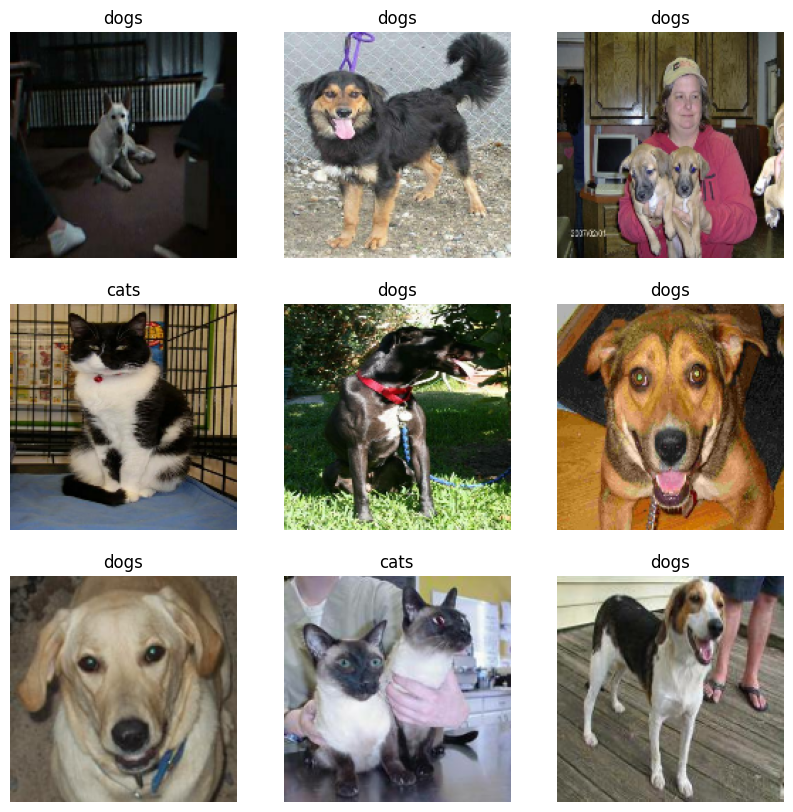

In [7]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
val_batches=tf.data.experimental.cardinality(validation_dataset)
test_dataset=validation_dataset.take(val_batches//5)
validation_dataset=validation_dataset.skip(val_batches//5)

In [11]:
AUTOTUNE=tf.data.AUTOTUNE
train_dataset=train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset=validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset=test_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

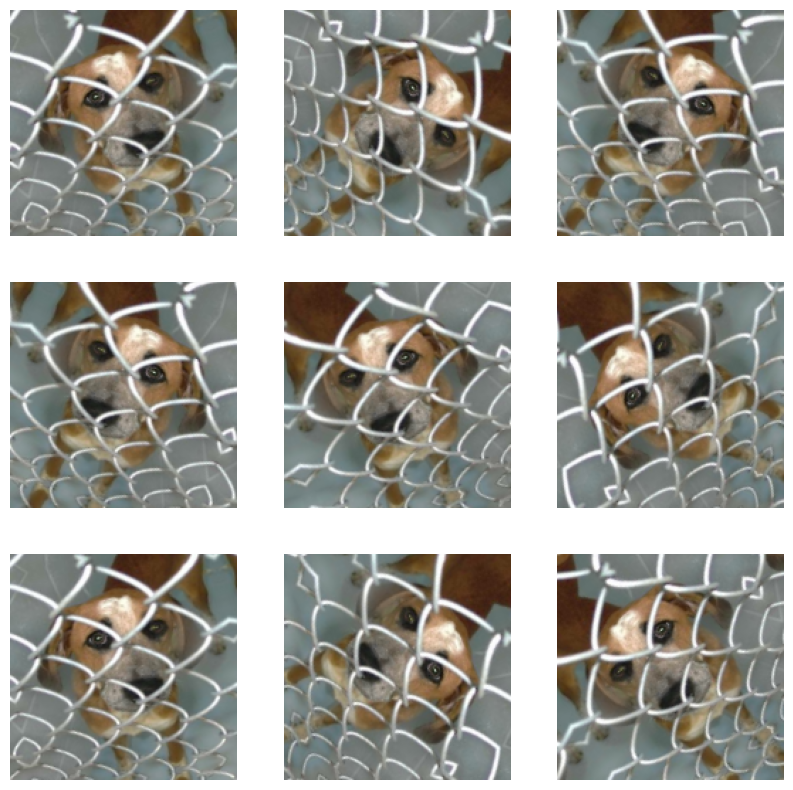

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [15]:
preprocess_input=tf.keras.applications.mobilenet_v2.preprocess_input

In [18]:
rescale=tf.keras.layers.Rescaling(1./127.5,offset=-1)

In [23]:
IMG_SHAPE=IMG_SIZE+(3,)
base_model=tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')

In [24]:
base_model.trainable=False

In [25]:
image_batch,label_batch=next(iter(train_dataset))
feature_batch=base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [28]:
global_average_layer=tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average=global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [29]:
prediction_layer=tf.keras.layers.Dense(1,activation='sigmoid')
prediction_batch=prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [30]:
inputs=tf.keras.layers.Input(shape=(160,160,3))
x=data_augmentation(inputs)
x=preprocess_input(x)
x=base_model(x,training=False)
x=global_average_layer(x)
x=tf.keras.layers.Dropout(0.2)(x)
outputs=prediction_layer(x)
model=tf.keras.Model(inputs,outputs)


In [32]:
len(model.trainable_variables)

2

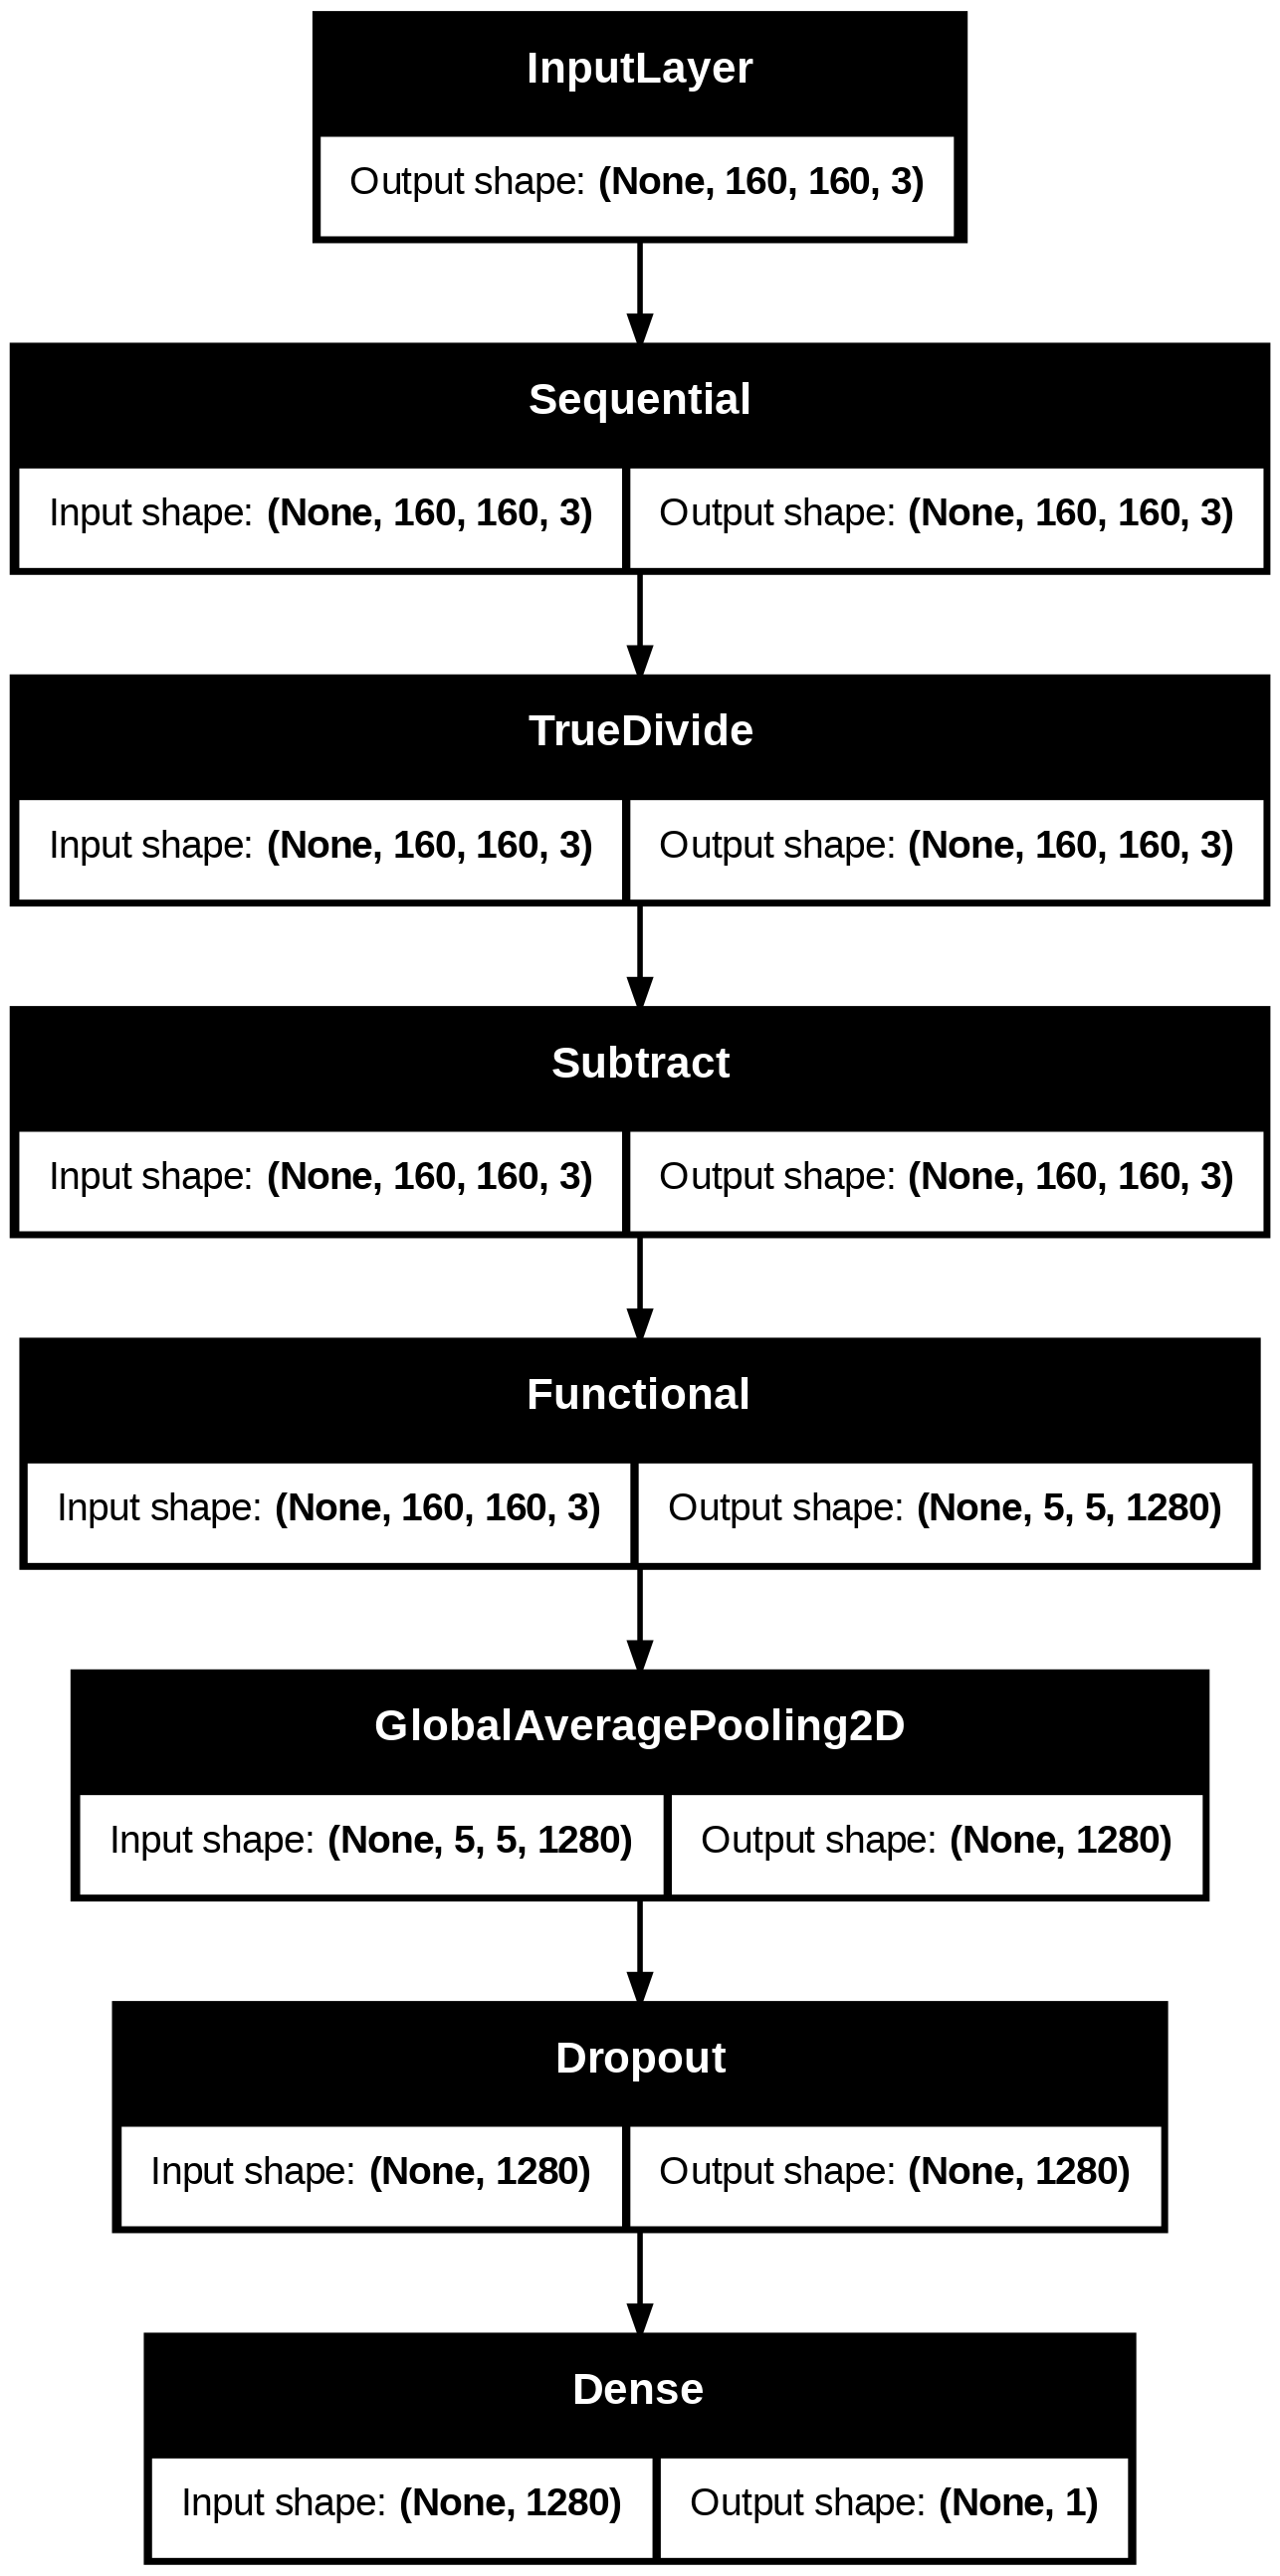

In [33]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [35]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5,name='accuracy')])

In [36]:
initial_epochs=10
loss0,accuracy0=model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 850ms/step - accuracy: 0.4484 - loss: 0.8242


In [40]:
history=model.fit(train_dataset,epochs=initial_epochs,validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.4923 - loss: 0.8363 - val_accuracy: 0.6931 - val_loss: 0.5800
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6720 - loss: 0.6074 - val_accuracy: 0.8688 - val_loss: 0.4188
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7841 - loss: 0.4686 - val_accuracy: 0.9257 - val_loss: 0.3189
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8367 - loss: 0.3926 - val_accuracy: 0.9443 - val_loss: 0.2560
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8680 - loss: 0.3299 - val_accuracy: 0.9530 - val_loss: 0.2176
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8763 - loss: 0.2969 - val_accuracy: 0.9604 - val_loss: 0.1912
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9049 - loss: 0.2598 - val_accuracy: 0.9592 - val_loss: 0.1687
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8902 - loss: 0.2630 - val_accuracy: 0.9653 - val_loss

In [41]:
image_batch,label_batch=test_dataset.as_numpy_iterator().next()
predictions=model.predict_on_batch(image_batch).flatten()
predictions=tf.where(predictions<0.5,0,1)
print('Predictions:\n',predictions.numpy())
print('Labels:\n',label_batch)

Predictions:
 [0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0]
Labels:
 [0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0]


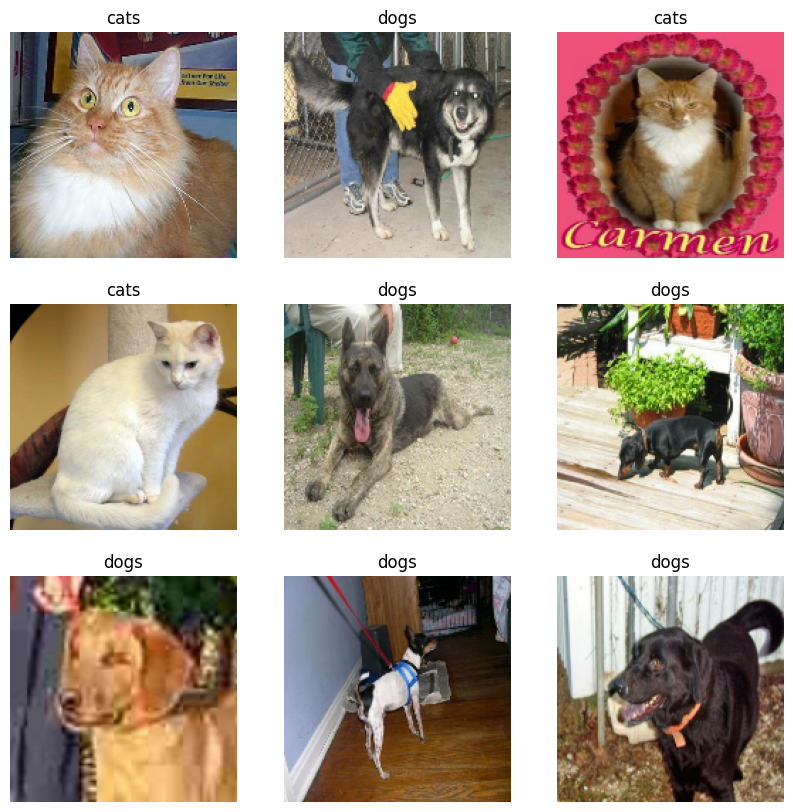

In [42]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
